In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='125Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='125Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (2400, 28, 62)
test (800, 28, 62)
validation (128, 28, 62)
Ntrain =  2400
Ntest =  800
Nvalidation =  128


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [5]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  52.875
	 Validation accuracy  43.75
	 Test accuracy  49.375
	 Epoch Loss  111.19764709472656
Epoch Number :  1
	 Training accuracy:  52.708333333333336
	 Validation accuracy  37.5
	 Test accuracy  47.625
	 Epoch Loss  110.98031616210938
Epoch Number :  2
	 Training accuracy:  53.375
	 Validation accuracy  37.5
	 Test accuracy  48.875
	 Epoch Loss  110.4345932006836
Epoch Number :  3
	 Training accuracy:  53.666666666666664
	 Validation accuracy  40.625
	 Test accuracy  48.625
	 Epoch Loss  110.2816162109375
Epoch Number :  4
	 Training accuracy:  56.666666666666664
	 Validation accuracy  37.5
	 Test accuracy  49.5
	 Epoch Loss  110.03362274169922
Epoch Number :  5
	 Training accuracy:  58.916666666666664
	 Validation accuracy  37.5
	 Test accuracy  50.875
	 Epoch Loss  109.48350524902344
Epoch Number :  6
	 Training accuracy:  61.791666666666664
	 Validation accuracy  43.75
	 Test accuracy  52.5
	 Epoch Loss  108.5030746459961
Epoch 

Epoch Number :  59
	 Training accuracy:  92.41666666666667
	 Validation accuracy  77.34375
	 Test accuracy  77.5
	 Epoch Loss  54.59444808959961
Epoch Number :  60
	 Training accuracy:  91.58333333333333
	 Validation accuracy  71.875
	 Test accuracy  78.375
	 Epoch Loss  56.00437927246094
Epoch Number :  61
	 Training accuracy:  90.91666666666667
	 Validation accuracy  76.5625
	 Test accuracy  79.375
	 Epoch Loss  53.290096282958984
Epoch Number :  62
	 Training accuracy:  88.875
	 Validation accuracy  75.0
	 Test accuracy  81.625
	 Epoch Loss  54.60894012451172
Epoch Number :  63
	 Training accuracy:  91.41666666666667
	 Validation accuracy  76.5625
	 Test accuracy  78.875
	 Epoch Loss  53.73370361328125
Epoch Number :  64
	 Training accuracy:  90.83333333333333
	 Validation accuracy  83.59375
	 Test accuracy  76.375
	 Epoch Loss  52.84651565551758
Epoch Number :  65
	 Training accuracy:  91.625
	 Validation accuracy  73.4375
	 Test accuracy  76.75
	 Epoch Loss  54.33086395263672
Epoc

Epoch Number :  17
	 Training accuracy:  81.66666666666667
	 Validation accuracy  67.1875
	 Test accuracy  73.5
	 Epoch Loss  95.0769271850586
Epoch Number :  18
	 Training accuracy:  82.75
	 Validation accuracy  67.1875
	 Test accuracy  73.875
	 Epoch Loss  94.28612518310547
Epoch Number :  19
	 Training accuracy:  82.45833333333333
	 Validation accuracy  74.21875
	 Test accuracy  75.0
	 Epoch Loss  92.31484985351562
Epoch Number :  20
	 Training accuracy:  83.70833333333333
	 Validation accuracy  75.0
	 Test accuracy  78.125
	 Epoch Loss  91.03471374511719
Epoch Number :  21
	 Training accuracy:  84.875
	 Validation accuracy  77.34375
	 Test accuracy  78.0
	 Epoch Loss  90.37590026855469
Epoch Number :  22
	 Training accuracy:  84.625
	 Validation accuracy  79.6875
	 Test accuracy  75.25
	 Epoch Loss  90.11769104003906
Epoch Number :  23
	 Training accuracy:  87.20833333333333
	 Validation accuracy  80.46875
	 Test accuracy  78.5
	 Epoch Loss  89.4201431274414
Epoch Number :  24
	 Tr

Epoch Number :  76
	 Training accuracy:  95.58333333333333
	 Validation accuracy  82.8125
	 Test accuracy  78.125
	 Epoch Loss  45.544979095458984
Epoch Number :  77
	 Training accuracy:  95.58333333333333
	 Validation accuracy  81.25
	 Test accuracy  78.75
	 Epoch Loss  47.658416748046875
Epoch Number :  78
	 Training accuracy:  95.54166666666667
	 Validation accuracy  81.25
	 Test accuracy  77.75
	 Epoch Loss  44.720149993896484
Epoch Number :  79
	 Training accuracy:  94.25
	 Validation accuracy  87.5
	 Test accuracy  79.875
	 Epoch Loss  45.246978759765625
Epoch Number :  80
	 Training accuracy:  84.58333333333333
	 Validation accuracy  85.9375
	 Test accuracy  77.25
	 Epoch Loss  45.582069396972656
Epoch Number :  81
	 Training accuracy:  95.70833333333333
	 Validation accuracy  82.03125
	 Test accuracy  77.125
	 Epoch Loss  45.55488586425781
Epoch Number :  82
	 Training accuracy:  95.0
	 Validation accuracy  83.59375
	 Test accuracy  77.125
	 Epoch Loss  45.86471176147461
Epoch 

Epoch Number :  34
	 Training accuracy:  91.54166666666667
	 Validation accuracy  75.0
	 Test accuracy  83.125
	 Epoch Loss  57.98538589477539
Epoch Number :  35
	 Training accuracy:  90.125
	 Validation accuracy  75.0
	 Test accuracy  80.75
	 Epoch Loss  56.045379638671875
Epoch Number :  36
	 Training accuracy:  92.0
	 Validation accuracy  75.0
	 Test accuracy  82.875
	 Epoch Loss  56.25601577758789
Epoch Number :  37
	 Training accuracy:  91.95833333333333
	 Validation accuracy  75.0
	 Test accuracy  80.875
	 Epoch Loss  56.603546142578125
Epoch Number :  38
	 Training accuracy:  89.70833333333333
	 Validation accuracy  74.21875
	 Test accuracy  83.25
	 Epoch Loss  55.70332717895508
Epoch Number :  39
	 Training accuracy:  90.75
	 Validation accuracy  74.21875
	 Test accuracy  83.625
	 Epoch Loss  54.04001235961914
Epoch Number :  40
	 Training accuracy:  91.75
	 Validation accuracy  68.75
	 Test accuracy  80.75
	 Epoch Loss  54.159568786621094
Epoch Number :  41
	 Training accuracy

Epoch Number :  93
	 Training accuracy:  96.29166666666667
	 Validation accuracy  75.0
	 Test accuracy  78.5
	 Epoch Loss  36.73058319091797
Epoch Number :  94
	 Training accuracy:  96.08333333333333
	 Validation accuracy  73.4375
	 Test accuracy  78.75
	 Epoch Loss  37.130558013916016
Epoch Number :  95
	 Training accuracy:  95.91666666666667
	 Validation accuracy  72.65625
	 Test accuracy  80.0
	 Epoch Loss  36.117557525634766
Epoch Number :  96
	 Training accuracy:  96.375
	 Validation accuracy  73.4375
	 Test accuracy  79.5
	 Epoch Loss  34.89967727661133
Epoch Number :  97
	 Training accuracy:  95.41666666666667
	 Validation accuracy  73.4375
	 Test accuracy  80.0
	 Epoch Loss  36.230064392089844
Epoch Number :  98
	 Training accuracy:  96.29166666666667
	 Validation accuracy  76.5625
	 Test accuracy  79.375
	 Epoch Loss  37.12571716308594
Epoch Number :  99
	 Training accuracy:  94.625
	 Validation accuracy  68.75
	 Test accuracy  82.75
	 Epoch Loss  37.968017578125
Repetition 3


Epoch Number :  52
	 Training accuracy:  91.5
	 Validation accuracy  73.4375
	 Test accuracy  74.25
	 Epoch Loss  59.21244430541992
Epoch Number :  53
	 Training accuracy:  92.95833333333333
	 Validation accuracy  71.09375
	 Test accuracy  76.0
	 Epoch Loss  60.17173385620117
Epoch Number :  54
	 Training accuracy:  91.625
	 Validation accuracy  72.65625
	 Test accuracy  78.125
	 Epoch Loss  57.58608627319336
Epoch Number :  55
	 Training accuracy:  91.375
	 Validation accuracy  75.78125
	 Test accuracy  73.0
	 Epoch Loss  59.177978515625
Epoch Number :  56
	 Training accuracy:  92.91666666666667
	 Validation accuracy  69.53125
	 Test accuracy  78.25
	 Epoch Loss  57.102394104003906
Epoch Number :  57
	 Training accuracy:  93.20833333333333
	 Validation accuracy  68.75
	 Test accuracy  77.5
	 Epoch Loss  57.31773376464844
Epoch Number :  58
	 Training accuracy:  93.45833333333333
	 Validation accuracy  69.53125
	 Test accuracy  76.875
	 Epoch Loss  58.20254898071289
Epoch Number :  59


Epoch Number :  10
	 Training accuracy:  60.041666666666664
	 Validation accuracy  54.6875
	 Test accuracy  45.125
	 Epoch Loss  109.82532501220703
Epoch Number :  11
	 Training accuracy:  60.208333333333336
	 Validation accuracy  49.21875
	 Test accuracy  45.5
	 Epoch Loss  109.39561462402344
Epoch Number :  12
	 Training accuracy:  62.458333333333336
	 Validation accuracy  41.40625
	 Test accuracy  43.75
	 Epoch Loss  109.14813995361328
Epoch Number :  13
	 Training accuracy:  63.958333333333336
	 Validation accuracy  40.625
	 Test accuracy  47.25
	 Epoch Loss  109.42115783691406
Epoch Number :  14
	 Training accuracy:  64.45833333333333
	 Validation accuracy  44.53125
	 Test accuracy  47.625
	 Epoch Loss  108.59703826904297
Epoch Number :  15
	 Training accuracy:  65.29166666666667
	 Validation accuracy  43.75
	 Test accuracy  50.0
	 Epoch Loss  108.25337219238281
Epoch Number :  16
	 Training accuracy:  65.375
	 Validation accuracy  45.3125
	 Test accuracy  51.125
	 Epoch Loss  107

Epoch Number :  69
	 Training accuracy:  94.70833333333333
	 Validation accuracy  78.90625
	 Test accuracy  78.125
	 Epoch Loss  53.80558395385742
Epoch Number :  70
	 Training accuracy:  92.0
	 Validation accuracy  79.6875
	 Test accuracy  78.375
	 Epoch Loss  53.00086975097656
Epoch Number :  71
	 Training accuracy:  93.70833333333333
	 Validation accuracy  78.90625
	 Test accuracy  78.25
	 Epoch Loss  51.24806594848633
Epoch Number :  72
	 Training accuracy:  93.54166666666667
	 Validation accuracy  80.46875
	 Test accuracy  76.5
	 Epoch Loss  50.701358795166016
Epoch Number :  73
	 Training accuracy:  94.45833333333333
	 Validation accuracy  80.46875
	 Test accuracy  77.5
	 Epoch Loss  52.33828353881836
Epoch Number :  74
	 Training accuracy:  90.08333333333333
	 Validation accuracy  81.25
	 Test accuracy  79.25
	 Epoch Loss  48.98538589477539
Epoch Number :  75
	 Training accuracy:  93.70833333333333
	 Validation accuracy  80.46875
	 Test accuracy  76.5
	 Epoch Loss  52.9913101196

Epoch Number :  27
	 Training accuracy:  84.20833333333333
	 Validation accuracy  73.4375
	 Test accuracy  72.875
	 Epoch Loss  87.5505142211914
Epoch Number :  28
	 Training accuracy:  86.25
	 Validation accuracy  72.65625
	 Test accuracy  76.0
	 Epoch Loss  86.20401763916016
Epoch Number :  29
	 Training accuracy:  86.0
	 Validation accuracy  75.0
	 Test accuracy  74.25
	 Epoch Loss  83.94583129882812
Epoch Number :  30
	 Training accuracy:  86.70833333333333
	 Validation accuracy  67.1875
	 Test accuracy  74.75
	 Epoch Loss  82.63238525390625
Epoch Number :  31
	 Training accuracy:  86.875
	 Validation accuracy  65.625
	 Test accuracy  77.0
	 Epoch Loss  81.42959594726562
Epoch Number :  32
	 Training accuracy:  87.45833333333333
	 Validation accuracy  70.3125
	 Test accuracy  77.5
	 Epoch Loss  80.14151763916016
Epoch Number :  33
	 Training accuracy:  87.5
	 Validation accuracy  78.125
	 Test accuracy  75.125
	 Epoch Loss  78.40326690673828
Epoch Number :  34
	 Training accuracy: 

Epoch Number :  86
	 Training accuracy:  94.54166666666667
	 Validation accuracy  77.34375
	 Test accuracy  72.875
	 Epoch Loss  45.07648468017578
Epoch Number :  87
	 Training accuracy:  94.25
	 Validation accuracy  78.90625
	 Test accuracy  75.5
	 Epoch Loss  47.68653106689453
Epoch Number :  88
	 Training accuracy:  93.5
	 Validation accuracy  75.78125
	 Test accuracy  77.625
	 Epoch Loss  45.40067672729492
Epoch Number :  89
	 Training accuracy:  94.625
	 Validation accuracy  83.59375
	 Test accuracy  77.625
	 Epoch Loss  43.32221221923828
Epoch Number :  90
	 Training accuracy:  93.91666666666667
	 Validation accuracy  80.46875
	 Test accuracy  74.625
	 Epoch Loss  45.02015686035156
Epoch Number :  91
	 Training accuracy:  94.70833333333333
	 Validation accuracy  81.25
	 Test accuracy  76.875
	 Epoch Loss  43.37495040893555
Epoch Number :  92
	 Training accuracy:  93.91666666666667
	 Validation accuracy  71.875
	 Test accuracy  74.125
	 Epoch Loss  45.187477111816406
Epoch Number 

Epoch Number :  45
	 Training accuracy:  85.29166666666667
	 Validation accuracy  58.59375
	 Test accuracy  75.125
	 Epoch Loss  63.20783615112305
Epoch Number :  46
	 Training accuracy:  87.08333333333333
	 Validation accuracy  60.15625
	 Test accuracy  71.625
	 Epoch Loss  61.1335563659668
Epoch Number :  47
	 Training accuracy:  86.125
	 Validation accuracy  67.1875
	 Test accuracy  78.5
	 Epoch Loss  60.92388153076172
Epoch Number :  48
	 Training accuracy:  86.45833333333333
	 Validation accuracy  57.03125
	 Test accuracy  73.75
	 Epoch Loss  60.91593551635742
Epoch Number :  49
	 Training accuracy:  88.875
	 Validation accuracy  65.625
	 Test accuracy  72.25
	 Epoch Loss  60.61805725097656
Epoch Number :  50
	 Training accuracy:  87.45833333333333
	 Validation accuracy  60.9375
	 Test accuracy  72.125
	 Epoch Loss  59.74925231933594
Epoch Number :  51
	 Training accuracy:  87.45833333333333
	 Validation accuracy  60.15625
	 Test accuracy  72.125
	 Epoch Loss  60.1243896484375
Epo

Epoch Number :  3
	 Training accuracy:  57.583333333333336
	 Validation accuracy  42.96875
	 Test accuracy  51.125
	 Epoch Loss  109.3750228881836
Epoch Number :  4
	 Training accuracy:  59.583333333333336
	 Validation accuracy  41.40625
	 Test accuracy  50.375
	 Epoch Loss  108.872314453125
Epoch Number :  5
	 Training accuracy:  62.541666666666664
	 Validation accuracy  45.3125
	 Test accuracy  51.75
	 Epoch Loss  107.75251007080078
Epoch Number :  6
	 Training accuracy:  67.79166666666667
	 Validation accuracy  48.4375
	 Test accuracy  52.0
	 Epoch Loss  106.87116241455078
Epoch Number :  7
	 Training accuracy:  70.45833333333333
	 Validation accuracy  44.53125
	 Test accuracy  53.25
	 Epoch Loss  105.61168670654297
Epoch Number :  8
	 Training accuracy:  72.70833333333333
	 Validation accuracy  45.3125
	 Test accuracy  52.375
	 Epoch Loss  104.0260009765625
Epoch Number :  9
	 Training accuracy:  76.20833333333333
	 Validation accuracy  36.71875
	 Test accuracy  56.75
	 Epoch Loss 

Epoch Number :  61
	 Training accuracy:  96.33333333333333
	 Validation accuracy  80.46875
	 Test accuracy  79.25
	 Epoch Loss  44.609100341796875
Epoch Number :  62
	 Training accuracy:  95.66666666666667
	 Validation accuracy  79.6875
	 Test accuracy  79.625
	 Epoch Loss  44.01665115356445
Epoch Number :  63
	 Training accuracy:  96.08333333333333
	 Validation accuracy  85.9375
	 Test accuracy  79.375
	 Epoch Loss  45.231658935546875
Epoch Number :  64
	 Training accuracy:  94.75
	 Validation accuracy  85.9375
	 Test accuracy  78.125
	 Epoch Loss  43.33284378051758
Epoch Number :  65
	 Training accuracy:  96.0
	 Validation accuracy  83.59375
	 Test accuracy  77.875
	 Epoch Loss  44.791297912597656
Epoch Number :  66
	 Training accuracy:  94.91666666666667
	 Validation accuracy  86.71875
	 Test accuracy  79.5
	 Epoch Loss  42.9736442565918
Epoch Number :  67
	 Training accuracy:  95.66666666666667
	 Validation accuracy  83.59375
	 Test accuracy  78.875
	 Epoch Loss  42.6873664855957
E

Epoch Number :  19
	 Training accuracy:  79.54166666666667
	 Validation accuracy  57.03125
	 Test accuracy  69.25
	 Epoch Loss  90.7972640991211
Epoch Number :  20
	 Training accuracy:  80.875
	 Validation accuracy  60.9375
	 Test accuracy  66.5
	 Epoch Loss  88.43724822998047
Epoch Number :  21
	 Training accuracy:  81.20833333333333
	 Validation accuracy  67.96875
	 Test accuracy  67.5
	 Epoch Loss  88.03704833984375
Epoch Number :  22
	 Training accuracy:  82.58333333333333
	 Validation accuracy  64.84375
	 Test accuracy  72.25
	 Epoch Loss  86.51679229736328
Epoch Number :  23
	 Training accuracy:  82.375
	 Validation accuracy  70.3125
	 Test accuracy  71.875
	 Epoch Loss  85.11746215820312
Epoch Number :  24
	 Training accuracy:  82.70833333333333
	 Validation accuracy  70.3125
	 Test accuracy  71.625
	 Epoch Loss  81.02890014648438
Epoch Number :  25
	 Training accuracy:  82.83333333333333
	 Validation accuracy  66.40625
	 Test accuracy  72.375
	 Epoch Loss  80.82832336425781
Epo

Epoch Number :  78
	 Training accuracy:  94.91666666666667
	 Validation accuracy  78.90625
	 Test accuracy  79.0
	 Epoch Loss  44.191307067871094
Epoch Number :  79
	 Training accuracy:  95.04166666666667
	 Validation accuracy  82.03125
	 Test accuracy  77.625
	 Epoch Loss  45.742008209228516
Epoch Number :  80
	 Training accuracy:  95.5
	 Validation accuracy  77.34375
	 Test accuracy  78.875
	 Epoch Loss  46.05171203613281
Epoch Number :  81
	 Training accuracy:  93.16666666666667
	 Validation accuracy  81.25
	 Test accuracy  83.125
	 Epoch Loss  46.08294677734375
Epoch Number :  82
	 Training accuracy:  95.41666666666667
	 Validation accuracy  79.6875
	 Test accuracy  80.25
	 Epoch Loss  44.70804977416992
Epoch Number :  83
	 Training accuracy:  95.875
	 Validation accuracy  76.5625
	 Test accuracy  78.0
	 Epoch Loss  41.913021087646484
Epoch Number :  84
	 Training accuracy:  95.16666666666667
	 Validation accuracy  81.25
	 Test accuracy  77.625
	 Epoch Loss  43.16707229614258
Epoch

Epoch Number :  36
	 Training accuracy:  91.5
	 Validation accuracy  63.28125
	 Test accuracy  76.75
	 Epoch Loss  60.93230056762695
Epoch Number :  37
	 Training accuracy:  89.91666666666667
	 Validation accuracy  72.65625
	 Test accuracy  77.875
	 Epoch Loss  60.3067626953125
Epoch Number :  38
	 Training accuracy:  92.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  76.25
	 Epoch Loss  60.0645866394043
Epoch Number :  39
	 Training accuracy:  91.95833333333333
	 Validation accuracy  74.21875
	 Test accuracy  77.0
	 Epoch Loss  61.89713668823242
Epoch Number :  40
	 Training accuracy:  92.5
	 Validation accuracy  71.875
	 Test accuracy  75.75
	 Epoch Loss  57.31293487548828
Epoch Number :  41
	 Training accuracy:  91.70833333333333
	 Validation accuracy  74.21875
	 Test accuracy  76.0
	 Epoch Loss  57.413726806640625
Epoch Number :  42
	 Training accuracy:  89.91666666666667
	 Validation accuracy  75.0
	 Test accuracy  79.125
	 Epoch Loss  58.424102783203125
Epoch Number

Epoch Number :  95
	 Training accuracy:  96.83333333333333
	 Validation accuracy  78.90625
	 Test accuracy  77.0
	 Epoch Loss  36.9595832824707
Epoch Number :  96
	 Training accuracy:  95.04166666666667
	 Validation accuracy  74.21875
	 Test accuracy  78.0
	 Epoch Loss  34.27256774902344
Epoch Number :  97
	 Training accuracy:  96.91666666666667
	 Validation accuracy  76.5625
	 Test accuracy  76.375
	 Epoch Loss  38.15338134765625
Epoch Number :  98
	 Training accuracy:  95.20833333333333
	 Validation accuracy  75.0
	 Test accuracy  76.75
	 Epoch Loss  38.751094818115234
Epoch Number :  99
	 Training accuracy:  97.375
	 Validation accuracy  75.0
	 Test accuracy  77.125
	 Epoch Loss  36.83790969848633


torch.Size([10, 100])
0


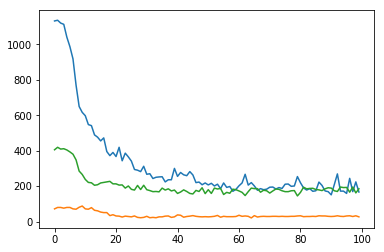

1


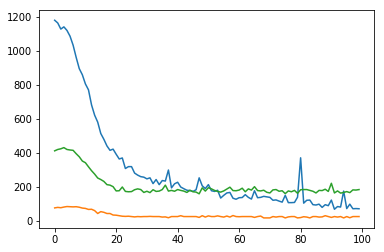

2


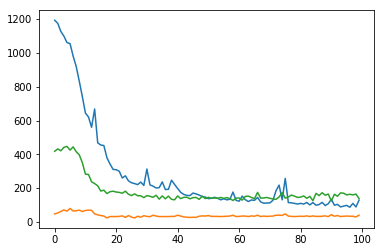

3


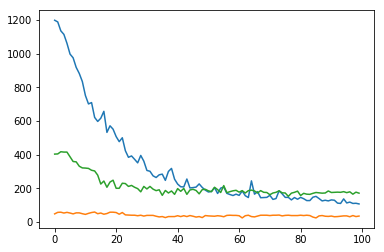

4


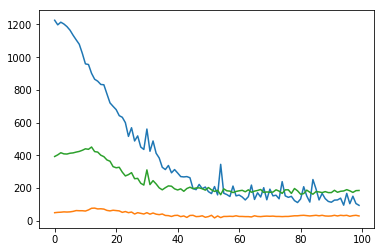

5


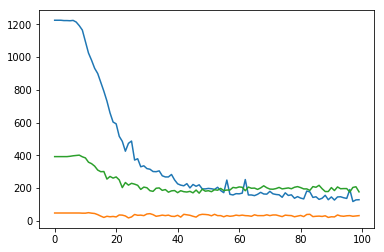

6


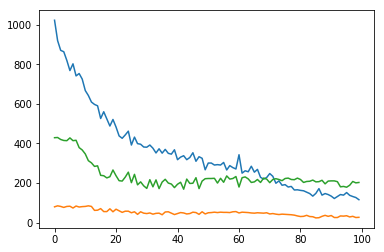

7


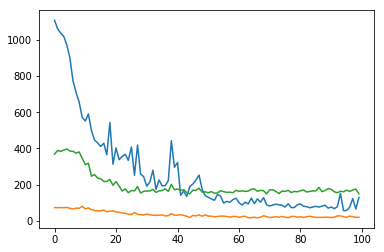

8


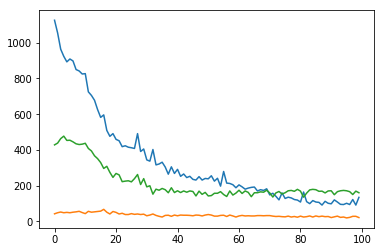

9


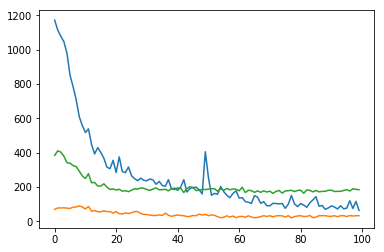

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


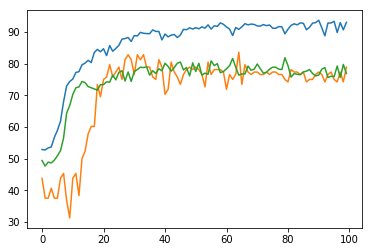

1


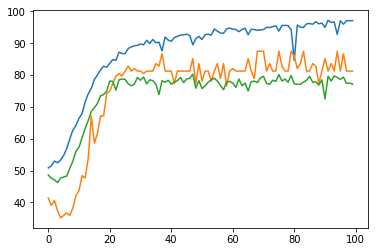

2


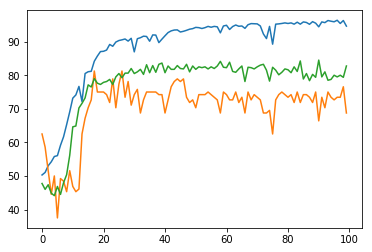

3


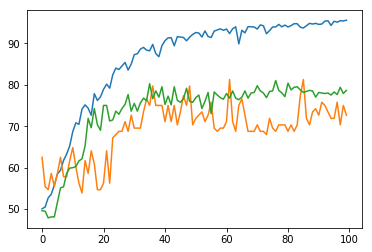

4


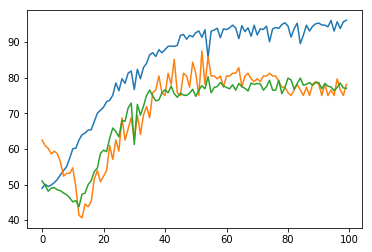

5


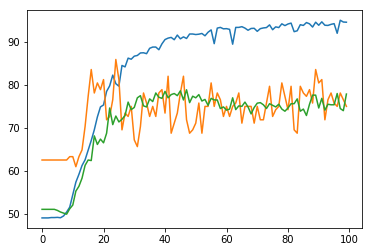

6


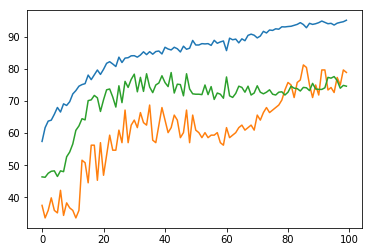

7


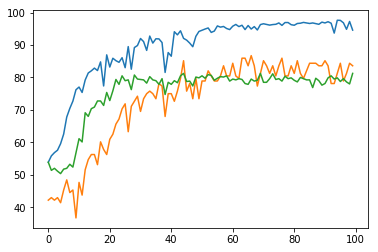

8


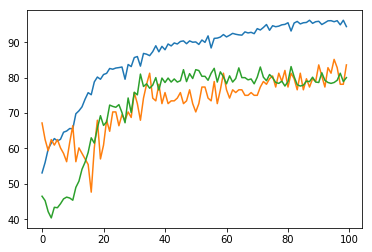

9


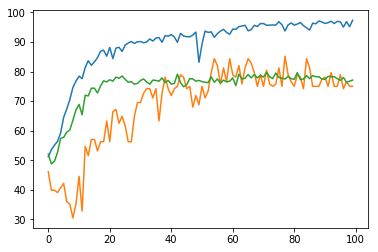

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(100,)
Training accuracy 95.3%+-1.2462173700332642
Validation accuracy 77.6%+-4.529229164123535
Testing accuracy 78.3%+-2.2729384899139404


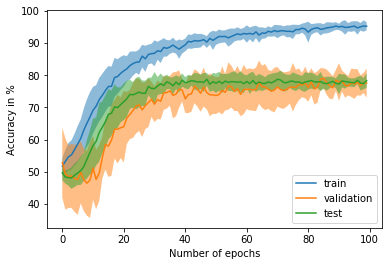

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(100))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))